In [62]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
from util.league_table import generate_league_table
from util.elo_calculator import initialize_team_stats, calculate_elo_ratings, loss_from_comparing_tables

from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta


%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Load data
competitions = load_competitions()
matches = load_matches(competition_id=9, season_id=27)

/Users/mpr/anaconda3/envs/BDEProject/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [64]:
# Generate league table
final_table = generate_league_table(matches)
final_table

,team,Matches,Wins,Draws,Losses,Goals_For,Goals_Against,Points,Goal_Difference
0,Bayern Munich,34,28,4,2,80,17,88,63
1,Borussia Dortmund,34,24,6,4,82,34,78,48
2,Bayer Leverkusen,34,18,6,10,56,40,60,16
3,Borussia Mönchengladbach,34,17,4,13,67,50,55,17
4,Schalke 04,34,15,7,12,51,49,52,2
5,FSV Mainz 05,34,14,8,12,46,42,50,4
6,Hertha Berlin,34,14,8,12,42,42,50,0
7,Wolfsburg,34,12,9,13,47,49,45,-2
8,FC Köln,34,10,13,11,38,42,43,-4
9,Hamburger SV,34,11,8,15,40,46,41,-6


In [ ]:
# Calculate Elo ratings
team_stats = initialize_team_stats(matches, starting_elo = 5000)
elo_ratings, elo_history = calculate_elo_ratings(team_stats, matches, K_FACTOR=1, HOME_ADVANTAGE=0.00)

# Update team stats with Elo ratings
team_stats['elo_rating'] = team_stats.index.map(elo_ratings.to_dict())
team_stats = team_stats.sort_values(by= 'elo_rating', ascending= False)

print (loss_from_comparing_tables(final_table,team_stats))

6


/Users/mpr/Desktop/Repo/FootballDSAI/util/elo_calculator.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_ratings[home_team] += K_FACTOR * (actual_home - expected_home)


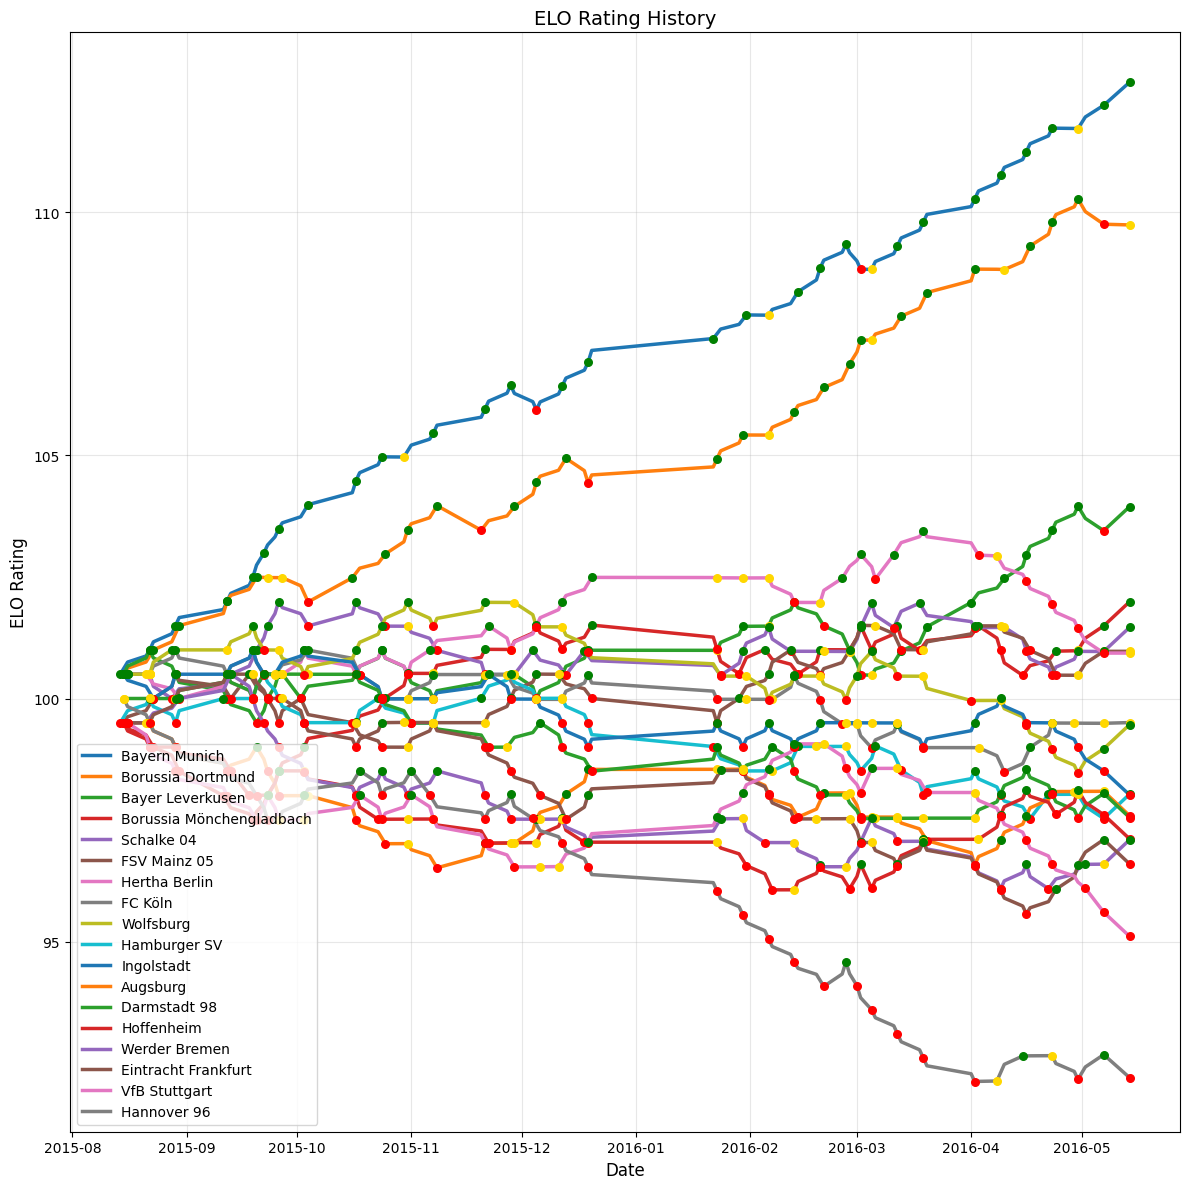

In [95]:
elo_history_df = pd.DataFrame(elo_history)
#selected_teams = ['Barcelona', 'Real Madrid']
selected_teams = team_stats.index.tolist()
team_history = elo_history_df
#team_history = team_history[team_history['date'] > '2014-12-31']

elo_pivot = team_history.pivot(index='date', columns='team', values='elo')
elo_pivot = elo_pivot.sort_index().interpolate()

plt.figure(figsize=(12, 12))

result_colors = {'win': 'green', 'loss': 'red', 'draw': 'gold'}

for team in selected_teams:
    plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5)

    team_points = team_history[team_history['team'] == team]
    for _, row in team_points.iterrows():
        plt.scatter(row['plot_date'], row['elo'], color=result_colors[row['result']], s=30, zorder=5)


plt.title('ELO Rating History', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()